# Clustering techniques for portfolio ESG screening


## Import necessary libraries

Before we import the necessary libraries, let's do some housekeeping: install and update some libraries, mute warnings, and assign CPU thread counts (if we are using cloud environment)

In [3]:
# Install and upgrade (run only once):
!pip install scikit-learn-extra
#!pip install --upgrade joblib
#!pip install --upgrade bottleneck
#!pip install scikit-learn --upgrade
#!pip install --upgrade pandas

In [4]:
# Set number of CPUs to 0.
# Reason: 
# On local machines, you don't have to worry about. Python will auto select the number of CPUs to use for its calculations
# On the Cloude computing services, such as Anaconda Cloud, this functionality is limited and it cannot auto-determine CPUs. So we
# manually have to set it to zero to tell Python to use virtual CPU.
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '0'

# We can disable warnings that are about the future package implementations and ignore them for now:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as sch
import seaborn as sns

## Load ESG score data

In [6]:
# Loading the ESG scores data (replace 'path_to_your_file.csv' with your file path)
esg_scores = pd.read_csv('data/esg_scores.csv')

# Cleaning the ticker column to remove the two-letter word and 'Equity'
esg_scores['ticker'] = esg_scores['ticker'].apply(lambda x: x.split()[0])

In [7]:
# This is the entire dataset
esg_scores

,ticker,E_score,S_score,G_score,ESG_score
0,AAL,96.30,99.95,73.30,89.85
1,AAME,52.08,63.80,5.62,40.50
2,AAOI,85.16,23.35,61.09,56.53
3,AAON,83.33,30.98,46.20,53.50
4,AAPL,44.38,95.57,37.39,59.11
...,...,...,...,...,...
1969,ZS,86.88,42.43,10.69,46.66
1970,ZUMZ,70.77,30.98,69.76,57.17
1971,ZVO,66.46,70.74,91.59,76.27
1972,ZYNE,12.74,54.03,34.30,33.69


In [8]:
# This subset of data will be used for clustering:

# Selecting relevant columns for clustering (E_score, S_score, G_score)
features = esg_scores[['E_score', 'S_score', 'G_score']]

features

,E_score,S_score,G_score
0,96.30,99.95,73.30
1,52.08,63.80,5.62
2,85.16,23.35,61.09
3,83.33,30.98,46.20
4,44.38,95.57,37.39
...,...,...,...
1969,86.88,42.43,10.69
1970,70.77,30.98,69.76
1971,66.46,70.74,91.59
1972,12.74,54.03,34.30


## K-means clustering

K-means clustering is a popular unsupervised machine learning algorithm used for partitioning a dataset into a pre-defined number of clusters. 

### Understanding the Elbow Method and Calculation of SSE

When performing clustering analysis, one key challenge is determining the optimal number of clusters (K) that best represent the structure of the data. Since the ideal number of clusters is not known in advance, we need to try different values of K and evaluate each model based on a specific criterion. One widely used approach for this purpose is the Elbow Method, which relies on the Sum of Squared Errors (SSE).

#### What is Sum of Squared Errors (SSE)?
SSE, also known as **"inertia"** in K-means clustering, measures the compactness of the clusters. 
- Inertia = SSE in the context of KMeans.
- It is defined as the sum of the squared distances between each data point and the centroid of its assigned cluster.
- Lower SSE values indicate that data points are closer to their cluster centroids, meaning the clusters are tight and well-defined.
- When you see **"inertia"** in KMeans or **"SSE"** in Elbow plots, they are referring to the same **measure of clustering quality**, representing the compactness of the clusters formed.

#### How the Elbow Method Works
The Elbow Method helps identify the optimal number of clusters by plotting the SSE for different values of K and looking for an "elbow" point where the rate of decrease sharply changes. This point suggests a balance between the number of clusters and the compactness of the clusters. After this point, adding more clusters provides diminishing returns in terms of reducing SSE.

#### Code Explanation
The code snippet below demonstrates how to calculate the SSE for a range of cluster numbers, from K=1 to K=10. This allows us to observe how the SSE changes as the number of clusters increases.

```python
# Calculating the Sum of Squared Errors (SSE) for a range of cluster numbers
sse = []  # An empty list to store SSE values
k_range = range(1, 11)  # Define the range of cluster numbers to try, from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # Initialize KMeans with the current number of clusters
    kmeans.fit(scaled_features)  # Fit the KMeans model to the standardized data
    sse.append(kmeans.inertia_)  # Append the SSE (inertia) to the list

In [9]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Calculating the Sum of Squared Errors (SSE) for a range of cluster numbers
sse = []
k_range = range(1, 11)  # You can adjust the range as needed
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

### Interactive plot of the SSE results

In [10]:
optimal_k = 4  # Set this based on where you see the elbow visually

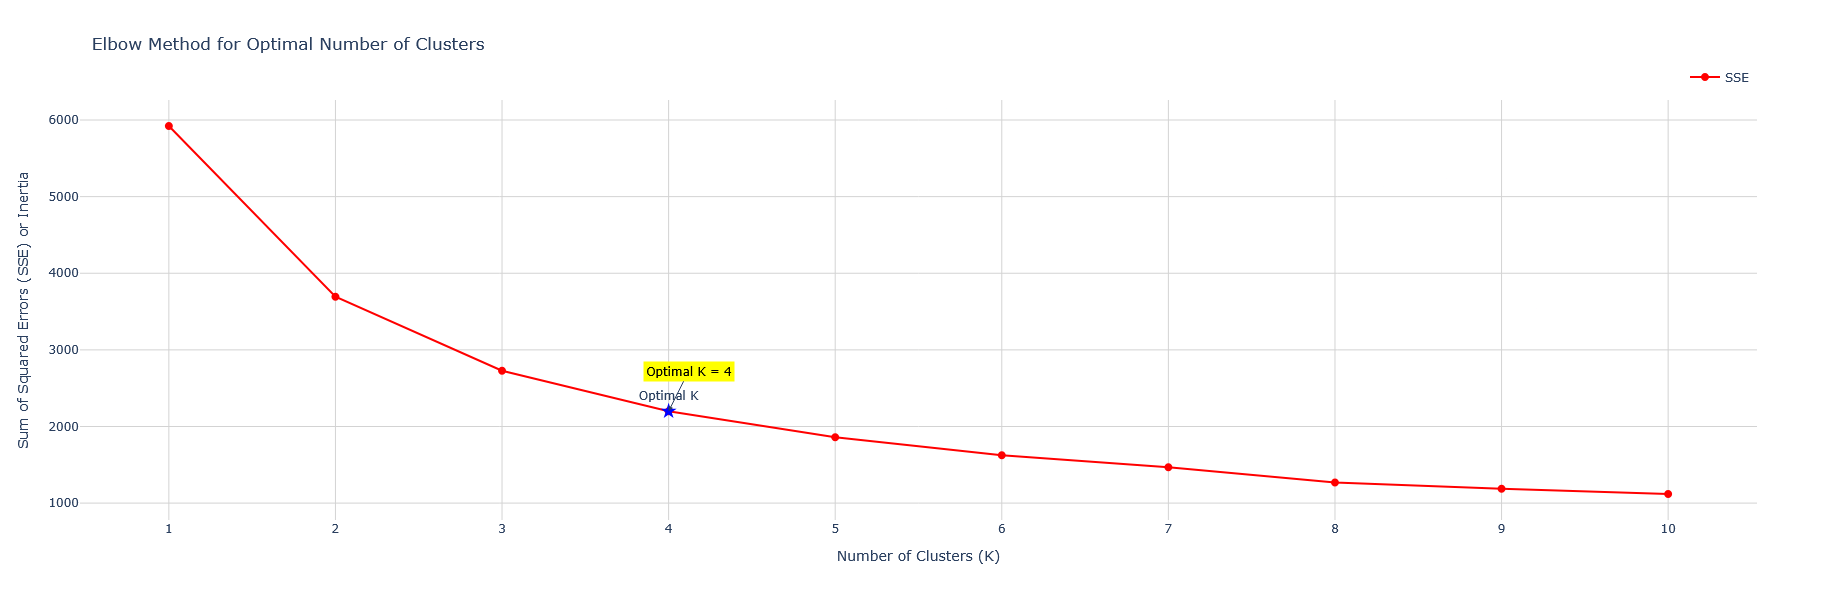

In [11]:
# Creating the Elbow plot using Plotly
fig = go.Figure()

# Adding SSE data as a scatter plot
fig.add_trace(go.Scatter(
    x=list(k_range),
    y=sse,
    mode='lines+markers',
    marker=dict(color='red', size=8),
    line=dict(width=2),
    name='SSE'
))

# Highlighting the "elbow" point for clarity
fig.add_trace(go.Scatter(
    x=[optimal_k],
    y=[sse[optimal_k - 1]],
    mode='markers+text',
    marker=dict(color='blue', size=12, symbol='star'),
    text=['Optimal K'],
    textposition='top center',
    showlegend=False
))

# Customizing the layout for improved visuals
fig.update_layout(
    title='Elbow Method for Optimal Number of Clusters',
    xaxis_title='Number of Clusters (K)',
    yaxis_title='Sum of Squared Errors (SSE) or Inertia',
    template='plotly_white',  # Light background theme
    width=900,
    height=600,
    xaxis=dict(
        dtick=1,  # Step size of 1 on the x-axis
        gridcolor='LightGray',
        zerolinecolor='Gray'
    ),
    yaxis=dict(
        gridcolor='LightGray',
        zerolinecolor='Gray'
    ),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Adding annotations to highlight key information
fig.add_annotation(
    x=optimal_k,
    y=sse[optimal_k - 1],
    text=f"Optimal K = {optimal_k}",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-40,
    bgcolor="yellow",
    font=dict(color='black')
)

fig.show()

### Interactive plot of clusters

Choose your final choice of number of clusters you want to use and plot the points in clusters:

In [12]:
my_choice_n_clusters=4

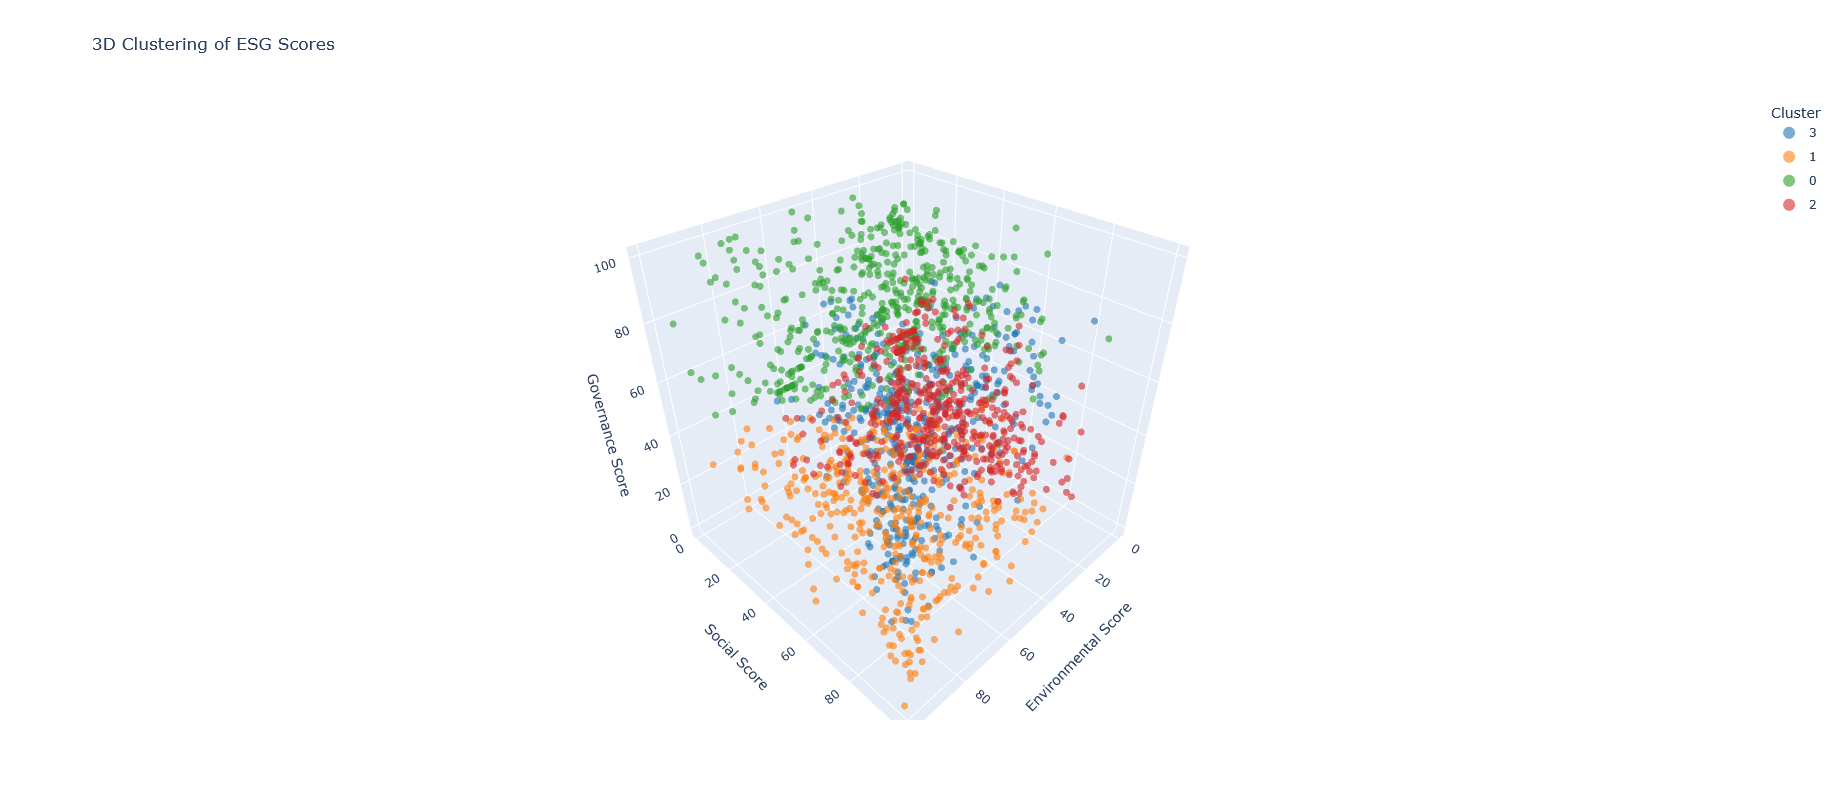

In [13]:
# Applying KMeans with 3 clusters as a demonstration
kmeans = KMeans(n_clusters=my_choice_n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Converting Cluster column to categorical type to ensure proper handling of discrete colors
#esg_scores['Cluster'] = clusters
esg_scores['Cluster'] = clusters.astype(str)  # Alternatively, use pd.Categorical if needed


# Plotting the ESG scores in a 3D space using Plotly
fig = px.scatter_3d(
    esg_scores,
    x='E_score',
    y='S_score',
    z='G_score',
    color='Cluster',
    title='3D Clustering of ESG Scores',
    labels={'E_score': 'E Score', 'S_score': 'S Score', 'G_score': 'G Score'},
    hover_data=['ticker'],
    color_discrete_sequence=px.colors.qualitative.D3   # Choose your desired colormap here: https://media.geeksforgeeks.org/wp-content/uploads/20220223155442/newplot12.png
)


# Adjusting figure size, marker size, and adding transparency
fig.update_traces(marker=dict(size=4, opacity=0.6))  # Smaller markers and added transparency

# Updating layout for improved visuals
fig.update_layout(scene=dict(
    xaxis_title='Environmental Score',
    yaxis_title='Social Score',
    zaxis_title='Governance Score'
    ),
    width=1000,  # Increased figure width
    height=800,   # Increased figure height
    legend=dict(
        itemsizing='constant',  # Ensures the size is consistent
        tracegroupgap=5,
        font=dict(size=12),
        #itemclick='toggleothers',
        #itemdoubleclick='toggle',
        itemwidth=30,
    )              
)
fig.show()

## Scaling and Feature Transformation

Proper scaling and transformation of features before applying KMeans can have a significant impact on the results. Here are some options:

- **StandardScaler (Z-score Normalization)**: Centers the data by subtracting the mean and scaling to unit variance. This is good for normally distributed data.
- **MinMaxScaler**: Scales the data to a specified range, usually between 0 and 1. This can help when you want to preserve relative differences between features without imposing a standard normal distribution.
- **RobustScaler**: Scales features using statistics that are robust to outliers, such as the median and interquartile range. This is useful when the data contains outliers.
- **Log Transformation**: Applies a log transformation to reduce skewness and make the data more normally distributed. This is beneficial when dealing with highly skewed features.
- **PCA (Principal Component Analysis)**: Reduces dimensionality and decorrelates the features before clustering. This can help in visualizing the data and improving the clustering performance if features are highly correlated.

We will need some kind of mesure to be able to judge if one scaling method is better than the other.

We can use **Inertia** for that. Recall, that when you see **"inertia"** in KMeans or **"SSE"**, they are referring to the same **measure of clustering quality**, representing the compactness of the clusters formed (that is how closely the data points in each cluster are grouped around their cluster centroid).

### Why Inertia is Used in KMeans Clustering

1. **Measure of Cluster Compactness**: Inertia provides a quantitative measure of how compact and well-defined the clusters are. A lower inertia value indicates that the data points are closer to their respective centroids, which suggests tighter, more distinct clusters.

2. **Optimization Criterion in KMeans**: The KMeans algorithm aims to minimize inertia during the clustering process. The algorithm iteratively adjusts the positions of the centroids and reassigns points to clusters in a way that reduces the total inertia, effectively seeking the best partition of the data.

3. **Simplicity and Efficiency**: Inertia is computationally efficient to calculate and provides a straightforward way to evaluate clustering quality. It is a natural fit for KMeans since the algorithm is directly designed to minimize this measure.

4. **Easy Interpretation with the Elbow Method**: Inertia can be plotted against different numbers of clusters (K) to create an Elbow plot. This visual tool helps identify the optimal number of clusters by looking for the "elbow" point, where additional clusters start to provide diminishing returns in reducing inertia.

### Limitations of Inertia

- **Scale Sensitivity**: Inertia depends on the scale of the data, meaning that features with larger numerical ranges can disproportionately affect the results. This is why scaling (using StandardScaler, MinMaxScaler, etc.) is often applied before clustering.
  
- **Bias Toward Spherical Clusters**: Inertia tends to favor clusters of similar size and spherical shape, which may not always be appropriate for data with complex cluster structures.

- **Does Not Penalize Overlapping Clusters**: Inertia does not account for the overlap between clusters. Even if clusters overlap, inertia might still be low if points are close to their assigned centroids.


In [14]:
my_choice_n_clusters=4

In [15]:
# Example using different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

In [16]:
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Scaler', 'Algorithm', 'Distance Metric', 'Inertia', 'Silhouette Score'])

# Apply different scalings and run KMeans
for name, scaler in scalers.items():
    scaled_features = scaler.fit_transform(features)
    
    # Running KMeans with different parameters
    kmeans = KMeans(n_clusters=my_choice_n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(scaled_features)

    # Calculating the Silhouette Score
    kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_)
    
    # Creating a new DataFrame for the result row
    new_row = pd.DataFrame([{
        'Scaler': name,
        'Algorithm': 'KMeans',
        'Distance Metric': 'Euclidean',
        'Inertia': kmeans.inertia_,
        'Silhouette Score': kmeans_silhouette
    }])

    # Concatenating the new row to the results DataFrame
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Running KMedoids with Manhattan distance
kmedoids = KMedoids(n_clusters=my_choice_n_clusters, metric='manhattan', random_state=42)
kmedoids.fit(scaled_features)
kmedoids_silhouette = silhouette_score(scaled_features, kmedoids.labels_)

# Creating a new DataFrame for KMedoids results
new_row_kmedoids = pd.DataFrame([{
    'Scaler': 'StandardScaler',  # Assuming StandardScaler was used for KMedoids for consistency
    'Algorithm': 'KMedoids',
    'Distance Metric': 'Manhattan',
    'Inertia': kmedoids.inertia_,
    'Silhouette Score': kmedoids_silhouette
}])

# Concatenating the KMedoids results
results_df = pd.concat([results_df, new_row_kmedoids], ignore_index=True)

results_df

,Scaler,Algorithm,Distance Metric,Inertia,Silhouette Score
0,StandardScaler,KMeans,Euclidean,2198.836894,0.316545
1,MinMaxScaler,KMeans,Euclidean,183.471119,0.316542
2,RobustScaler,KMeans,Euclidean,803.030994,0.307646
3,StandardScaler,KMedoids,Manhattan,1749.084454,0.300007


But... what if we want to check the Inertia and Silhouette Scores for different Scalers **AND** across different number of clusters?

In [17]:
# Initialize a DataFrame with predefined types to store all results
all_results_df = pd.DataFrame(columns=['n_clusters', 'Scaler', 'Algorithm', 'Distance Metric', 'Inertia', 'Silhouette Score'])

# Outer loop for different numbers of clusters
for n_clusters in range(2, 11):  # n_clusters ranging from 2 to 10
    # Apply different scalings and run KMeans and KMedoids for each n_clusters
    for name, scaler in scalers.items():
        scaled_features = scaler.fit_transform(features)
        
        # Running KMeans with different parameters
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
        kmeans.fit(scaled_features)
        
        # Calculating the Silhouette Score
        kmeans_silhouette = silhouette_score(scaled_features, kmeans.labels_)
        
        # Creating a new DataFrame for the KMeans result row
        new_row_kmeans = pd.DataFrame([{
            'n_clusters': n_clusters,
            'Scaler': name,
            'Algorithm': 'KMeans',
            'Distance Metric': 'Euclidean',
            'Inertia': kmeans.inertia_,
            'Silhouette Score': kmeans_silhouette
        }])

        # Concatenating the new KMeans row to the results DataFrame
        all_results_df = pd.concat([all_results_df, new_row_kmeans], ignore_index=True)

    # Running KMedoids with Manhattan distance for each n_clusters
    kmedoids = KMedoids(n_clusters=n_clusters, metric='manhattan', random_state=42)
    kmedoids.fit(scaled_features)
    kmedoids_silhouette = silhouette_score(scaled_features, kmedoids.labels_)

    # Creating a new DataFrame for KMedoids results
    new_row_kmedoids = pd.DataFrame([{
        'n_clusters': n_clusters,
        'Scaler': 'StandardScaler',  # Assuming StandardScaler was used for KMedoids for consistency
        'Algorithm': 'KMedoids',
        'Distance Metric': 'Manhattan',
        'Inertia': kmedoids.inertia_,
        'Silhouette Score': kmedoids_silhouette
    }])

    # Concatenating the KMedoids results
    all_results_df = pd.concat([all_results_df, new_row_kmedoids], ignore_index=True)

# Display the consolidated results
display(all_results_df)

,n_clusters,Scaler,Algorithm,Distance Metric,Inertia,Silhouette Score
0,2,StandardScaler,KMeans,Euclidean,3693.872933,0.333974
1,2,MinMaxScaler,KMeans,Euclidean,308.180438,0.333999
2,2,RobustScaler,KMeans,Euclidean,1301.746692,0.343874
3,2,StandardScaler,KMedoids,Manhattan,2274.325473,0.323309
4,3,StandardScaler,KMeans,Euclidean,2727.972864,0.322343
5,3,MinMaxScaler,KMeans,Euclidean,227.605746,0.322343
6,3,RobustScaler,KMeans,Euclidean,977.537369,0.322470
7,3,StandardScaler,KMedoids,Manhattan,1963.437272,0.311721
8,4,StandardScaler,KMeans,Euclidean,2198.836894,0.316545
9,4,MinMaxScaler,KMeans,Euclidean,183.471119,0.316542


In [18]:
# Applying a gradient color from red (low) to green (high) to the Silhouette Score column using Styler.map
styled_df = all_results_df.style.background_gradient(
    subset=['Silhouette Score'],
    cmap='PiYG',  # Red to Green colormap
    axis=0
).format(precision=2)  # Optional: format the numbers to 2 decimal places for better readability

In [19]:
styled_df

,n_clusters,Scaler,Algorithm,Distance Metric,Inertia,Silhouette Score
0,2,StandardScaler,KMeans,Euclidean,3693.87,0.33
1,2,MinMaxScaler,KMeans,Euclidean,308.18,0.33
2,2,RobustScaler,KMeans,Euclidean,1301.75,0.34
3,2,StandardScaler,KMedoids,Manhattan,2274.33,0.32
4,3,StandardScaler,KMeans,Euclidean,2727.97,0.32
5,3,MinMaxScaler,KMeans,Euclidean,227.61,0.32
6,3,RobustScaler,KMeans,Euclidean,977.54,0.32
7,3,StandardScaler,KMedoids,Manhattan,1963.44,0.31
8,4,StandardScaler,KMeans,Euclidean,2198.84,0.32
9,4,MinMaxScaler,KMeans,Euclidean,183.47,0.32


In [20]:
sorted_df = all_results_df.sort_values(by='Silhouette Score', ascending=False)

# Applying the gradient styling to the sorted DataFrame
styled_df = sorted_df.style.background_gradient(
    subset=['Silhouette Score'],
    cmap='PiYG',  # Red to Green colormap
    axis=0
).format(precision=2)  # Optional: format the numbers to 2 decimal places for better readability

# Display the sorted and styled DataFrame
styled_df

,n_clusters,Scaler,Algorithm,Distance Metric,Inertia,Silhouette Score
2,2,RobustScaler,KMeans,Euclidean,1301.75,0.34
1,2,MinMaxScaler,KMeans,Euclidean,308.18,0.33
0,2,StandardScaler,KMeans,Euclidean,3693.87,0.33
3,2,StandardScaler,KMedoids,Manhattan,2274.33,0.32
6,3,RobustScaler,KMeans,Euclidean,977.54,0.32
4,3,StandardScaler,KMeans,Euclidean,2727.97,0.32
5,3,MinMaxScaler,KMeans,Euclidean,227.61,0.32
12,5,StandardScaler,KMeans,Euclidean,1859.17,0.32
13,5,MinMaxScaler,KMeans,Euclidean,155.12,0.32
8,4,StandardScaler,KMeans,Euclidean,2198.84,0.32


### Understanding the Silhouette Score

The Silhouette Score is a metric used to evaluate the quality of clustering results. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from -1 to +1, where higher values indicate better-defined clusters.

#### How the Silhouette Score is Calculated:
- **Silhouette Score for a single point**: Calculated as $s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$, where:
  - $a(i)$ is the average distance of point $i$ to all other points in its own cluster (intra-cluster distance).
  - $b(i)$ is the average distance of point $i$ to points in the nearest cluster that it is not a part of (inter-cluster distance).
- **Overall Silhouette Score**: The average of the individual Silhouette Scores for all points in the dataset.

### Interpretation of Silhouette Scores

The Silhouette Score provides insight into the quality of clustering, with various ranges indicating different cluster separations and cohesion:

| Silhouette Score Range | Interpretation                            |
|------------------------|-------------------------------------------|
| **+0.71 to +1.0**      | Strong clustering structure; clusters are well-separated and distinct. Ideal scenario in clustering. |
| **+0.51 to +0.70**     | Reasonably strong structure; clusters are well-formed, but there may be some overlap or cohesion issues. |
| **+0.26 to +0.50**     | Moderate structure; clusters are present but may overlap significantly or have irregular shapes. |
| **0 to +0.25**         | Weak structure; clusters are poorly defined, overlap considerably, or there is significant noise. |
| **Negative Values**    | Incorrect clustering; points are likely assigned to the wrong clusters or clusters are not meaningful. |

### Detailed Interpretation:
- **High Silhouette Scores (+0.71 to +1.0)**: Clusters are highly distinct from each other, with well-separated boundaries. Points within clusters are closely packed, indicating effective clustering.
- **Moderate Scores (+0.26 to +0.50)**: Indicates average clustering performance where some clusters may overlap or be inconsistently shaped. Additional tuning or refinement of the clustering algorithm might be necessary.
- **Low Scores (0 to +0.25)**: Suggests that clustering is poor; the points do not form distinct groups, and the boundaries between clusters are blurred. This might be due to inadequate feature selection, too many clusters, or an inherently noisy dataset.
- **Negative Scores**: Indicate a mismatch in clustering where points are often assigned to the wrong clusters, implying that the clustering solution does not fit the data well.

This understanding of Silhouette Scores is essential for interpreting clustering results and making informed adjustments to the clustering approach, such as changing the number of clusters, distance measures, or feature scaling techniques.


In [21]:
my_choice_n_clusters=2
scaler =  RobustScaler()                    # Choose from StandardScaler(), MinMaxScaler(), RobustScaler()

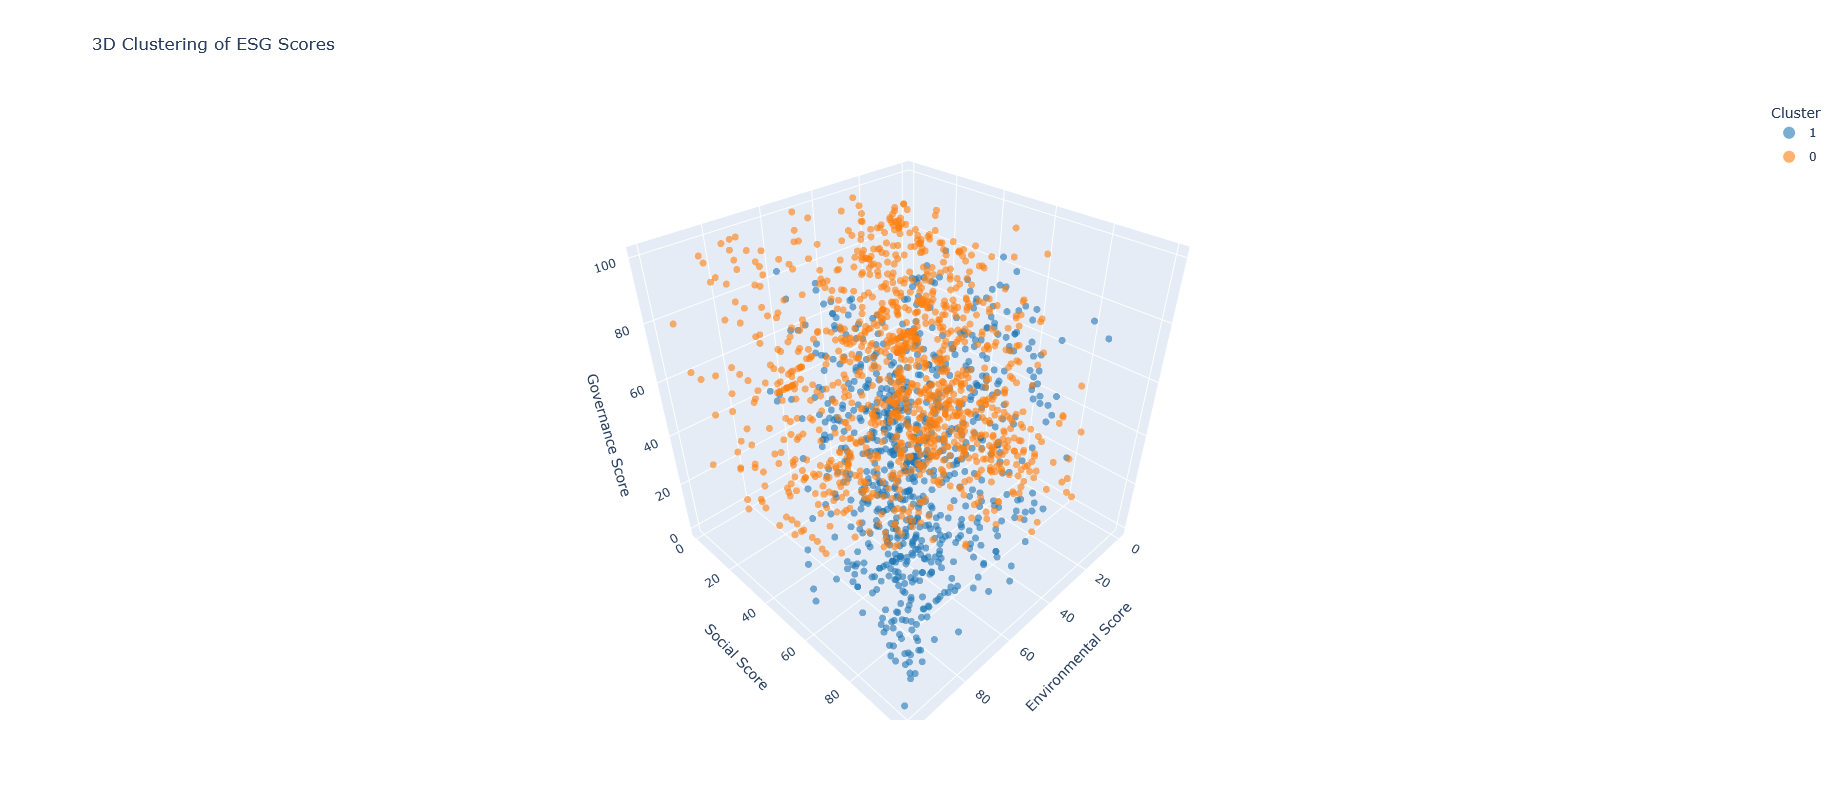

In [22]:
# Standardizing the features
scaled_features = scaler.fit_transform(features)

# Applying KMeans with 3 clusters as a demonstration
kmeans = KMeans(n_clusters=my_choice_n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Converting Cluster column to categorical type to ensure proper handling of discrete colors
#esg_scores['Cluster'] = clusters
esg_scores['Cluster'] = clusters.astype(str)  # Alternatively, use pd.Categorical if needed

# Plotting the ESG scores in a 3D space using Plotly
fig = px.scatter_3d(
    esg_scores,
    x='E_score',
    y='S_score',
    z='G_score',
    color='Cluster',
    title='3D Clustering of ESG Scores',
    labels={'E_score': 'E Score', 'S_score': 'S Score', 'G_score': 'G Score'},
    hover_data=['ticker'],
    color_discrete_sequence=px.colors.qualitative.D3   # Choose your desired colormap here: https://media.geeksforgeeks.org/wp-content/uploads/20220223155442/newplot12.png
)

# Adjusting figure size, marker size, and adding transparency
fig.update_traces(marker=dict(size=4, opacity=0.6))  # Smaller markers and added transparency

# Updating layout for improved visuals
fig.update_layout(scene=dict(
    xaxis_title='Environmental Score',
    yaxis_title='Social Score',
    zaxis_title='Governance Score'
    ),
    width=1000,  # Increased figure width
    height=800,   # Increased figure height
    legend=dict(
        itemsizing='constant',  # Ensures the size is consistent
        tracegroupgap=5,
        font=dict(size=12),
        #itemclick='toggleothers',
        #itemdoubleclick='toggle',
        itemwidth=30,
    )              
)
fig.show()

## Other clustering algorithms

### Spectral Clustering
- **Description**: Uses the eigenvalues of a similarity matrix (derived from graph theory) to perform dimensionality reduction before clustering.
- **Use Cases**: Effective for clustering data that is connected but not necessarily globular; can handle complex cluster structures.
- **Limitations**: Computationally expensive for large datasets; requires a well-defined similarity matrix.

In [23]:
# Importing necessary libraries
from sklearn.cluster import SpectralClustering

# Assuming 'features' contains the relevant columns E_score, S_score, G_score
# Example using different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize a DataFrame to store the results for Spectral Clustering
spectral_results_df = pd.DataFrame(columns=['n_clusters', 'Scaler', 'Algorithm', 'Affinity', 'Silhouette Score'])

# Outer loop for different numbers of clusters
for n_clusters in range(2, 11):  # n_clusters ranging from 2 to 10
    # Apply different scalings and run Spectral Clustering for each n_clusters
    for name, scaler in scalers.items():
        scaled_features = scaler.fit_transform(features)
        
        # Running Spectral Clustering with different parameters
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42, assign_labels='kmeans')
        labels = spectral.fit_predict(scaled_features)
        
        # Calculating the Silhouette Score
        spectral_silhouette = silhouette_score(scaled_features, labels)
        
        # Creating a new DataFrame for the Spectral Clustering result row
        new_row = pd.DataFrame([{
            'n_clusters': n_clusters,
            'Scaler': name,
            'Algorithm': 'Spectral Clustering',
            'Affinity': 'nearest_neighbors',
            'Silhouette Score': spectral_silhouette
        }])

        # Concatenating the new Spectral Clustering row to the results DataFrame
        spectral_results_df = pd.concat([spectral_results_df, new_row], ignore_index=True)

In [24]:
# Display the consolidated results
spectral_results_df

,n_clusters,Scaler,Algorithm,Affinity,Silhouette Score
0,2,StandardScaler,Spectral Clustering,nearest_neighbors,0.308072
1,2,MinMaxScaler,Spectral Clustering,nearest_neighbors,0.308126
2,2,RobustScaler,Spectral Clustering,nearest_neighbors,0.321540
3,3,StandardScaler,Spectral Clustering,nearest_neighbors,0.300491
4,3,MinMaxScaler,Spectral Clustering,nearest_neighbors,0.298785
5,3,RobustScaler,Spectral Clustering,nearest_neighbors,0.303396
6,4,StandardScaler,Spectral Clustering,nearest_neighbors,0.256720
7,4,MinMaxScaler,Spectral Clustering,nearest_neighbors,0.256732
8,4,RobustScaler,Spectral Clustering,nearest_neighbors,0.246374
9,5,StandardScaler,Spectral Clustering,nearest_neighbors,0.262753


### Birch (Balanced Iterative Reducing and Clustering using Hierarchies)

- **Description**: Efficiently handles large datasets by building a tree structure (CF tree) and clustering subclusters represented by tree nodes.
- **Use Cases**: Useful for large datasets and when the number of clusters is unknown or variable.
- **Limitations**: Less effective for very high-dimensional data.

In [25]:
# Importing necessary libraries
from sklearn.cluster import Birch

# Assuming 'features' contains the relevant columns E_score, S_score, G_score
# Example using different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Initialize a DataFrame with predefined types to store the Birch results
birch_results_df = pd.DataFrame(columns=['Scaler', 'Algorithm', 'Distance Metric', 'Inertia', 'Silhouette Score'])

# Loop through different scalers and apply Birch clustering
for name, scaler in scalers.items():
    scaled_features = scaler.fit_transform(features)
    
    # Running Birch clustering with default settings
    birch = Birch(n_clusters=3, threshold=0.25)  # You can fine-tune threshold further if needed
    birch.fit(scaled_features)
    
    # Calculating the Silhouette Score
    birch_silhouette = silhouette_score(scaled_features, birch.labels_)
    
    # Saving the results into the DataFrame
    new_row_birch = pd.DataFrame([{
        'Scaler': name,
        'Algorithm': 'Birch',
        'Distance Metric': 'Euclidean',  # Birch uses Euclidean distance internally
        'Inertia': 'N/A',  # Birch does not directly provide an inertia measure
        'Silhouette Score': birch_silhouette
    }])

    # Concatenating the new Birch row to the results DataFrame
    birch_results_df = pd.concat([birch_results_df, new_row_birch], ignore_index=True)

In [26]:
# Display the results
birch_results_df

,Scaler,Algorithm,Distance Metric,Inertia,Silhouette Score
0,StandardScaler,Birch,Euclidean,N/A,0.246283
1,MinMaxScaler,Birch,Euclidean,N/A,0.276581
2,RobustScaler,Birch,Euclidean,N/A,0.226198


### Agglomerative Clustering

- **Description**: A type of hierarchical clustering that starts with each point as its own cluster and merges clusters iteratively based on a linkage criterion.
- **Use Cases**: Suitable for discovering nested clusters and hierarchical relationships.
- **Limitations**: Computational cost is high for large datasets; sensitive to noise.

In [27]:
# Importing necessary libraries for Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Assuming 'features' contains the relevant columns E_score, S_score, G_score
# Scaling the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Applying Hierarchical Clustering using Agglomerative Clustering
# Choosing 3 clusters as an example (adjust based on dendrogram observation)
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster_labels = hierarchical_clustering.fit_predict(scaled_features)

# Calculating the Silhouette Score for the hierarchical clustering
silhouette = silhouette_score(scaled_features, cluster_labels)

# Display the results
print(f"Silhouette Score for Hierarchical Clustering: {silhouette:.2f}")


Silhouette Score for Hierarchical Clustering: 0.26


### Hierarchical Clustering

- **Description**: Hierarchical clustering builds a hierarchy of clusters either by a bottom-up approach (Agglomerative) or top-down approach (Divisive).
- **Distance Measures**: Supports multiple distance metrics (e.g., Euclidean, Manhattan, Cosine).
- **Linkage Criteria**: Various methods like single, complete, average, and ward linkage define how clusters are merged.
- **Use Cases**: Effective for small to medium datasets and when the number of clusters is unknown. Provides a dendrogram, which helps visualize the merging process.
- **Limitations**: Computationally expensive for large datasets; sensitive to noise and outliers.

In [28]:
# Assuming 'features' contains the relevant columns E_score, S_score, G_score
# Assuming 'esg_scores' contains the original DataFrame with tickers
# Scaling the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Extracting ticker labels from the original DataFrame
labels = esg_scores['ticker'].values

In [29]:
# Define N, the number of points to select
# Original dataset contains aprox 2,000 rows of data, thus it will be difficult to visualise.
# So, for the purpose of visualisation, pick only 20-200 points:
N = 100

# Ensure that both arrays have the same length and that there are at least N elements
if len(labels) == len(scaled_features) and len(labels) >= N:
    # Generate N random indices from the arrays
    random_indices = np.random.choice(len(labels), size=N, replace=False)
    
    # Select the points at the random indices in both arrays
    labels_reduced = np.array(labels)[random_indices]
    scaled_features_reduced = scaled_features[random_indices]
    
    print("Random selection of points completed.")
else:
    print("Error: Arrays must have the same length and at least N elements.")

Random selection of points completed.


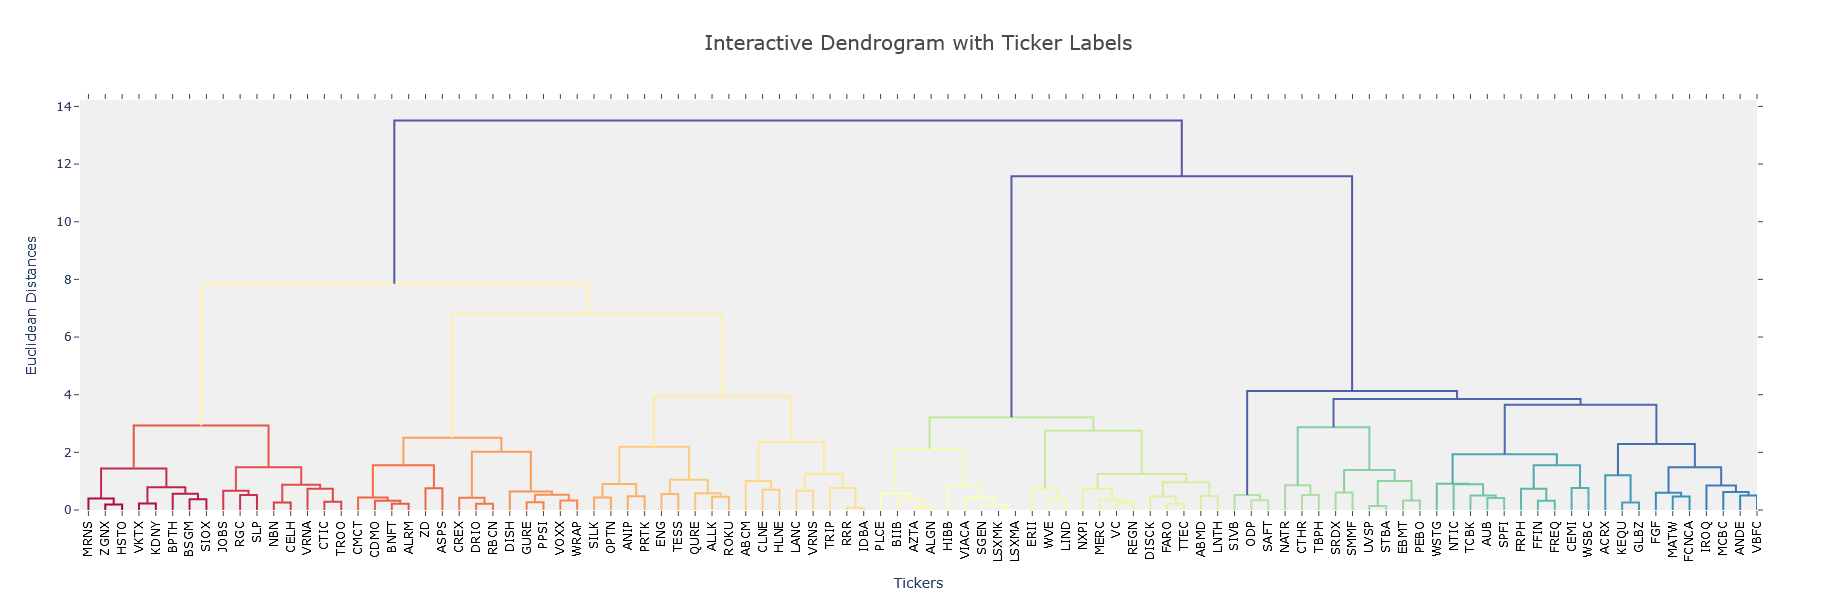

In [30]:
# Creating an interactive dendrogram using Plotly
fig = ff.create_dendrogram(
    scaled_features_reduced, 
    labels=labels_reduced,  # Adding ticker labels
    orientation='bottom',  
    linkagefun=lambda x: sch.linkage(x, method='ward')  # Use ward linkage
)

# Adding colours to clusters for better visualization
#fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='scatter'))
# Define a colour palette using seaborn or matplotlib
# Use any colormap; here, 'viridis' is chosen for a range of colours
colors = sns.color_palette("Spectral", len(fig['data'])).as_hex()

# Update line colors for each trace to make clusters more distinct
for i, trace in enumerate(fig['data']):
    trace.update(line=dict(color=colors[i % len(colors)], width=2))
    

# Updating layout for better readability
fig.update_layout(
    width=1800,
    height=600,
    title=dict(
        text='Interactive Dendrogram with Ticker Labels',
        x=0.5,
        xanchor='center',
        font=dict(size=20, color='#4a4a4a')),
    xaxis=dict(
        title='Tickers',
        showticklabels=True,
        tickangle=-90,
        tickfont=dict(size=12, color='black')
    ),
    yaxis=dict(
        title='Euclidean Distances',
        gridcolor='LightGray',
        zerolinecolor='Gray'
    ),
    plot_bgcolor='#f0f0f0'  # Light background color for contrast
)

# Display the interactive dendrogram
fig.show()

## Using ESG Scores Clustering for Portfolio Construction

Clustering based on Environmental, Social, and Governance (ESG) scores allows investors to group companies with similar ESG characteristics, providing a nuanced way to integrate sustainability into portfolio construction. This approach helps identify groups of companies that align with specific ESG investment goals, such as minimizing environmental impact, promoting social responsibility, or enhancing governance practices. Here's how clustering results, including visualizations like dendrograms, can be leveraged for ESG-driven portfolio construction:

### 1. Identifying Distinct ESG Profiles
- **Clustering Insight**: The clustering process groups companies with similar ESG profiles, revealing distinct clusters based on their ESG performance. For instance, one cluster might contain companies with high environmental scores but lower governance scores, while another might have a balanced performance across all ESG dimensions.
- **Dendrogram Visualization**: The dendrogram visually represents the hierarchical relationships between companies, showing how clusters are formed step-by-step based on ESG similarity. It highlights which companies are more closely related in terms of their ESG attributes.

**Application to Portfolio Construction**:
- **Targeted Investments**: Investors can use these clusters to create targeted portfolios. For instance, a portfolio focusing on high environmental performance can be constructed by selecting companies from a cluster characterized by strong environmental scores.
- **Avoiding High-Risk Groups**: Clusters that include companies with consistently poor ESG scores can be flagged as higher risk, allowing investors to avoid these groups in their portfolios.

### 2. Enhancing Diversification with ESG Clusters
- **Clustering Insight**: By identifying clusters with distinct ESG profiles, investors can diversify their portfolios not only by sector or market cap but also by ESG characteristics. This helps mitigate risks associated with ESG factors, such as regulatory changes, reputational risks, or environmental liabilities.

**Application to Portfolio Construction**:
- **Balanced ESG Exposure**: Investors can balance their portfolios by selecting companies from different ESG clusters, ensuring exposure to a variety of ESG profiles. For example, combining clusters of companies with high environmental scores and those with strong governance can lead to a more resilient portfolio.
- **Thematic Investing**: ESG clustering supports thematic investing by allowing investors to focus on specific sustainability themes. For instance, a cluster of companies excelling in social criteria can form the basis of a portfolio centered on social impact investing.

### 3. Informing Weighting Decisions Based on ESG Performance
- **Silhouette Score and Cluster Quality**: The silhouette score provides a measure of how well companies fit within their assigned clusters. Higher scores suggest well-defined clusters, indicating clear differences in ESG performance between groups. Investors can use these scores to validate the robustness of the clustering results.

**Application to Portfolio Construction**:
- **Weighting Strategies**: Investors can assign different weights to stocks within the portfolio based on their cluster's ESG performance. For example, stocks from a high-performing ESG cluster might be overweighted, while those from lower-performing clusters are underweighted or excluded.
- **Enhanced Screening**: The clustering approach allows for more nuanced screening criteria beyond simple ESG score thresholds, considering the overall profile of each cluster.

### 4. Identifying Outliers and Potential Risks
- **Clustering Insight**: Outliers identified in the clustering process represent companies that do not fit well into any cluster, often due to unique or extreme ESG characteristics. These companies might pose additional risks or opportunities.

**Application to Portfolio Construction**:
- **Risk Management**: Outliers with poor ESG scores may represent higher risks (e.g., potential for regulatory penalties or reputational damage). These can be flagged for exclusion or further analysis.
- **Opportunities for Engagement**: Outliers with high potential but specific ESG deficiencies can be targeted for engagement strategies, allowing investors to work with companies to improve their ESG practices.

### 5. Visualizing and Communicating ESG Strategies
- **Dendrogram and Cluster Visualization**: Visual tools like dendrograms help investors communicate their ESG investment strategy clearly. The hierarchical clustering visualization allows investors to present how their portfolios align with specific ESG objectives.

**Application to Portfolio Construction**:
- **Investor Communication**: Dendrograms can be used in presentations or reports to show how companies are grouped based on ESG criteria, making the investment strategy transparent and understandable to stakeholders.
- **Benchmarking and Performance Tracking**: Clusters can serve as benchmarks for tracking ESG performance over time, allowing investors to monitor whether the companies in their portfolios maintain or improve their ESG standings.

### Conclusion
Using ESG scores for clustering and visualizations like dendrograms provides a powerful toolset for constructing portfolios that align with specific sustainability goals. This approach enhances traditional financial analysis by incorporating a deeper understanding of a company’s ESG attributes, allowing for more informed, resilient, and responsible investment decisions. By using these techniques, investors can better manage ESG risks, capitalize on sustainability opportunities, and contribute to positive social and environmental outcomes.
